<a href="https://colab.research.google.com/github/rohan-vr/Natural-Language-Processing/blob/master/Eng_Hin_NMT_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all the necessary modules

In [0]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense, Bidirectional, TimeDistributed
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from keras.optimizers import RMSprop
from keras.models import load_model
import pandas as pd
from nltk.translate.bleu_score import corpus_bleu

Now comes the part of loading our cleaned English and Hindi datasets and create tokenizer for English dataset and Hindi dataset and then we find the max length of sentences of English and Hindi. At last we encode sequences to prepare training data and validation data.

In [11]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# load datasets
dataset = load_clean_sentences('en-hi-both.pkl')
train = load_clean_sentences('en-hi-train.pkl')
test = load_clean_sentences('en-hi-test.pkl')


# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))


# prepare hindi tokenizer
hin_tokenizer = create_tokenizer(dataset[:, 1])
hin_vocab_size = len(hin_tokenizer.word_index) + 1
hin_length = max_length(dataset[:, 1])
print('Hindi Vocabulary Size: %d' % hin_vocab_size)
print('Hindi Max Length: %d' % (hin_length))

# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(hin_tokenizer, hin_length, train[:, 1])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(hin_tokenizer, hin_length, test[:, 1])

English Vocabulary Size: 12550
English Max Length: 15
Hindi Vocabulary Size: 19645
Hindi Max Length: 17


Now comes the part to define our model. Lets do it!

In [12]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	model.add(Bidirectional(GRU(units=n_units)))
	model.add(RepeatVector(tar_timesteps))
	model.add(Bidirectional(GRU(n_units, return_sequences=True)))
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

model = define_model(eng_vocab_size, hin_vocab_size, eng_length, hin_length, 512)
rms = RMSprop(lr=0.002)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 15, 512)           6425600   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1024)              3148800   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 17, 1024)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 17, 1024)          4721664   
_________________________________________________________________
time_distributed_2 (TimeDist (None, 17, 19645)         20136125  
Total params: 34,432,189
Trainable params: 34,432,189
Non-trainable params: 0
_________________________________________________________________
None


Now let us save the model. Dont forget to save checkpoints.

In [0]:
filename = 'model.h1.5_may_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

Now let us train the model and keep a track of loss and validation loss which will help us to plot these two variables in a graph so we can visualize it easily.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 121500 samples, validate on 13500 samples
Epoch 1/10
121500/121500 [==============================] - 271s 2ms/step - loss: 1.6874 - val_loss: 1.2390

Epoch 00001: val_loss improved from inf to 1.23903, saving model to model.h1.5_may_20
Epoch 2/10
121500/121500 [==============================] - 272s 2ms/step - loss: 0.9720 - val_loss: 0.8565

Epoch 00002: val_loss improved from 1.23903 to 0.85654, saving model to model.h1.5_may_20
Epoch 3/10
121500/121500 [==============================] - 269s 2ms/step - loss: 0.6985 - val_loss: 0.7126

Epoch 00003: val_loss improved from 0.85654 to 0.71259, saving model to model.h1.5_may_20
Epoch 4/10
121500/121500 [==============================] - 271s 2ms/step - loss: 0.5584 - val_loss: 0.6450

Epoch 00004: val_loss improved from 0.71259 to 0.64500, saving model to model.h1.5_may_20
Epoch 5/10
121500/121500 [==============================] - 273s 2ms/step - loss: 0.4653 - val_loss: 0.6374

Epoch 00005: val_loss improved from 0.64500 to 0

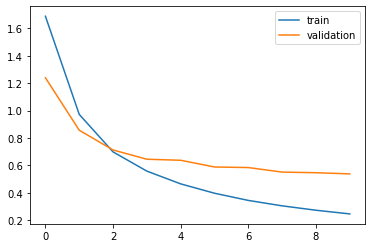

In [14]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), epochs=10, batch_size=512, validation_split=0.1, callbacks=[checkpoint],  verbose=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Okay so now we are done with training. As we can see the graph, that is a pretty smooth curve! Now is the time to test our model. First we will load the model then make predictions over the test dataset we created.

In [15]:
testX=testX[0:50] # lets take 50 sentences of test data set

model = load_model('/content/model.h1.5_may_20')

preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

# a function that is going to grab words.
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], hin_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], hin_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Okay so now time to see predictions. 

In [16]:
import pandas as pd
pred_df = pd.DataFrame({'input' : test[0:50,0], 'actual' : test[0:50,1], 'predicted' : preds_text})
pred_df.sample(15)

,input,actual,predicted
2,program attached,प्रोग्राम नहीं,प्रोग्राम नहीं
21,line up parentheses,पंक्ति ऊपर,पंक्ति ऊपर
44,the column the widget resides in,स्तंभ जिसमें विजेट रहता है,स्तंभ जिसमें विजेट रहता है
27,redo all,सभी फिर से करें,सभी à¤à¥
3,error the trigger key can only contain alphanu...,त्रुटि अक्षर और,त्रुटि अक्षर और
10,invalid message contents,अवैध संदेश अंतर्वस्तु,अवैध संदेश
46,you must specify a folder,आप अवश्य एक फ़ोल्डर निर्दिष्ठ करें,आप अवश्य एक फ़ोल्डर निर्दिष्ठ करें
9,atlantic madeira,एटलांटिकमडायरा,एटलांटिकमडायरा
34,description,वर्णनः,वर्णनः
14,remove,हटाएँ,हटाएँ


Okay so now we got some satisfying results. That is it. We are done with translation.